### DATA DISCOVERY


🔍 Loading source data...
🔍 Identifying asset columns...

🚀 Processing storedAssets...
✅ Saved 4 records to ../output/storedAssets.xlsx


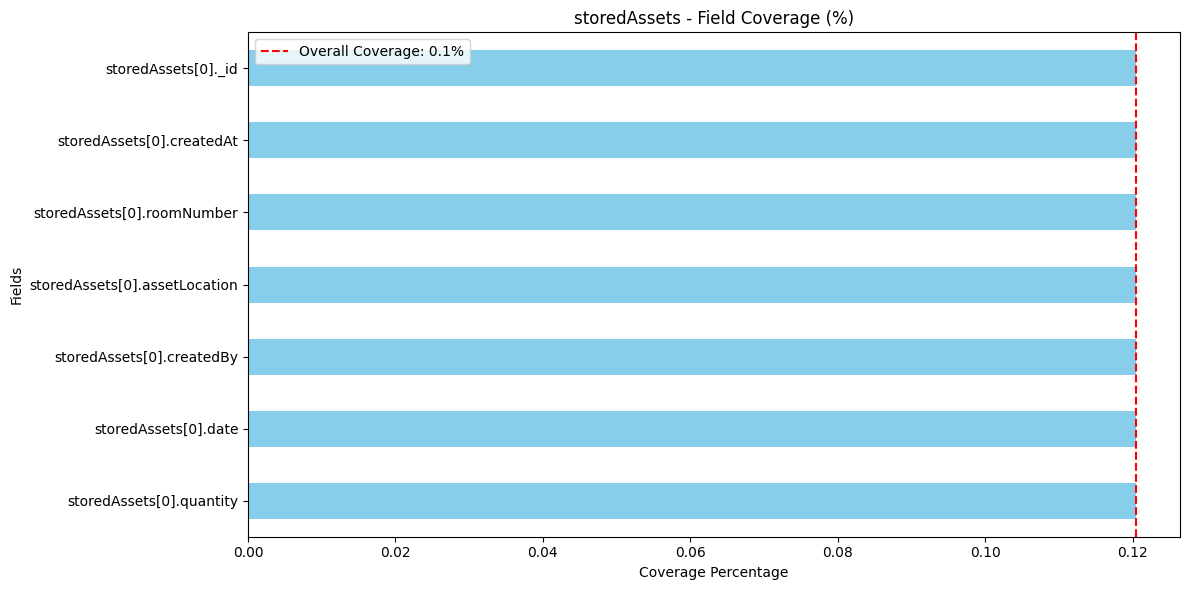


🚀 Processing displayedAssets...
✅ Saved 43 records to ../output/displayedAssets.xlsx


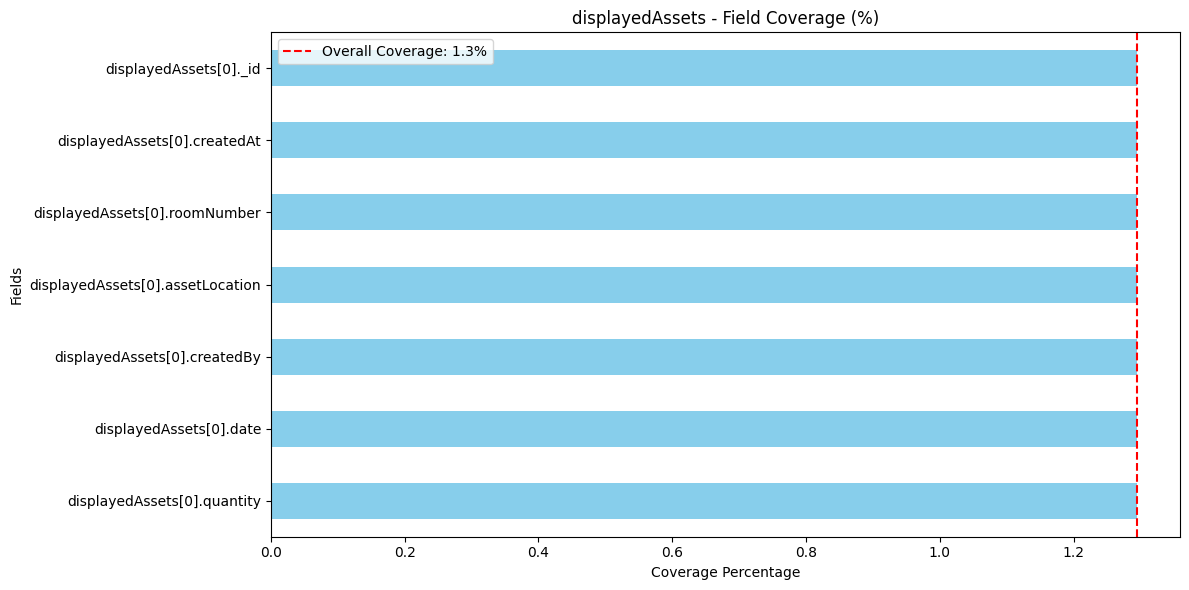


🚀 Processing borrowedAssets...
✅ Saved 146 records to ../output/borrowedAssets.xlsx


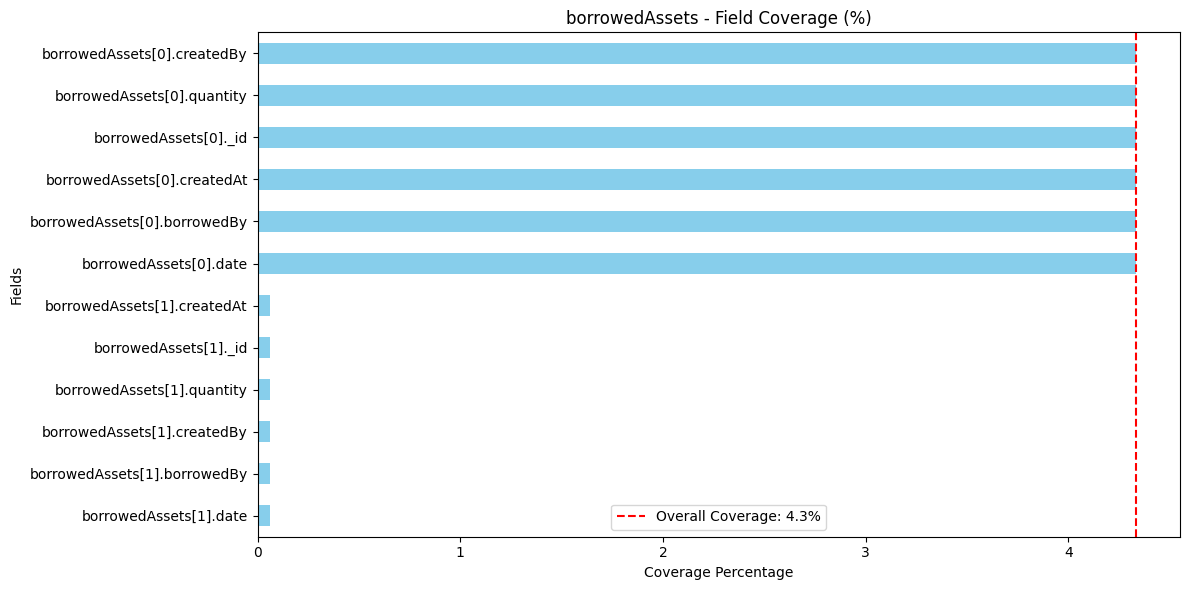


📊 Generating final report...

🌟 Data Processing Summary:
Total source records: 3322

STOREDASSETS:
- Records processed: 4
- Field coverage: 0.1%
- Top fields: 
storedAssets[0].quantity         0.120409
storedAssets[0].date             0.120409
storedAssets[0].createdBy        0.120409
storedAssets[0].assetLocation    0.120409
storedAssets[0].roomNumber       0.120409
dtype: float64

DISPLAYEDASSETS:
- Records processed: 43
- Field coverage: 1.3%
- Top fields: 
displayedAssets[0].quantity         1.294401
displayedAssets[0].date             1.294401
displayedAssets[0].createdBy        1.294401
displayedAssets[0].assetLocation    1.294401
displayedAssets[0].roomNumber       1.294401
dtype: float64

BORROWEDASSETS:
- Records processed: 146
- Field coverage: 2.2%
- Top fields: 
borrowedAssets[0].date          4.334738
borrowedAssets[0].borrowedBy    4.334738
borrowedAssets[0].quantity      4.334738
borrowedAssets[0].createdBy     4.334738
borrowedAssets[0].createdAt     4.334738
dtype: fl

In [5]:
import pandas as pd
import numpy as np
import re
import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# ------------------------
# Configuration
# ------------------------
SOURCE_FILE = '../proddata/kalayaan_inventories.csv'
TAIPEI_TZ = pytz.timezone('Asia/Taipei')
ASSET_TYPES = ['storedAssets', 'displayedAssets', 'borrowedAssets']

# ------------------------
# Helper Functions
# ------------------------
def convert_date(date_str, format_type):
    """Convert ISO date to specified format in Taipei time"""
    if pd.isna(date_str) or date_str in ['', 'None']:
        return ''
    
    try:
        # Parse ISO format (handle both with and without milliseconds)
        if 'T' in date_str and date_str.endswith('Z'):
            dt = datetime.fromisoformat(date_str.replace('Z', '+00:00'))
        else:
            dt = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%fZ') if '.' in date_str else datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
        
        # Convert to Taipei time
        dt = dt.astimezone(TAIPEI_TZ)
        
        if format_type == 'date':
            return dt.strftime('%m/%d/%Y')
        else:  # timestamp
            return dt.strftime('%m/%d/%Y %I:%M:%S %p')
    
    except Exception as e:
        print(f"Error converting date: {date_str} - {str(e)}")
        return date_str

def extract_asset_info(df):
    """Identify and extract asset columns from the DataFrame"""
    asset_pattern = re.compile(r'^(\w+)\[(\d+)\]\.(\w+)$')
    asset_data = defaultdict(lambda: defaultdict(list))
    
    for col in df.columns:
        match = asset_pattern.match(col)
        if match:
            asset_type, index, field = match.groups()
            asset_data[asset_type][int(index)].append((field, col))
    
    return asset_data

def process_asset_type(df, asset_type, asset_info):
    """Process and transform asset data for a specific type"""
    all_data = []
    column_map = {}
    
    # Process each index group
    for index, fields in asset_info.items():
        temp_df = df[['accessionId'] + [col for _, col in fields]].copy()
        
        # Rename columns
        for field, col in fields:
            new_name = f"{asset_type}{field[0].upper()}{field[1:]}"
            temp_df.rename(columns={col: new_name}, inplace=True)
            column_map[col] = new_name
        
        # Add to collection
        all_data.append(temp_df)
    
    # Combine all indices
    if all_data:
        combined = pd.concat(all_data, ignore_index=True)
        
        # Remove rows where all asset columns are null
        asset_cols = [col for col in combined.columns if col != 'accessionId']
        combined = combined.dropna(subset=asset_cols, how='all')
        
        return combined, column_map
    return pd.DataFrame(), {}

def analyze_coverage(df, asset_cols, asset_type):
    """Analyze and visualize data coverage for an asset type"""
    if not asset_cols:
        return pd.Series(dtype=float)
    
    # Calculate coverage statistics
    coverage = df[asset_cols].notnull().mean() * 100
    overall_coverage = df[asset_cols].notnull().any(axis=1).mean() * 100
    
    # Visualize coverage
    plt.figure(figsize=(12, 6))
    coverage.sort_values().plot(kind='barh', color='skyblue')
    plt.axvline(x=overall_coverage, color='r', linestyle='--', 
                label=f'Overall Coverage: {overall_coverage:.1f}%')
    plt.title(f'{asset_type} - Field Coverage (%)')
    plt.xlabel('Coverage Percentage')
    plt.ylabel('Fields')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{asset_type}_coverage.png')
    plt.show()
    
    return coverage

# ------------------------
# Main Processing
# ------------------------
def main():
    # Load and prepare data
    print("🔍 Loading source data...")
    df = pd.read_csv(SOURCE_FILE)
    df.rename(columns=lambda x: x.strip(), inplace=True)  # Clean column names
    
    # Ensure accessionId exists
    if 'accessionId' not in df.columns:
        print("❌ Error: 'accessionId' column not found in dataset")
        return
    
    # Extract asset information
    print("🔍 Identifying asset columns...")
    asset_info = extract_asset_info(df)
    
    # Process each asset type
    results = {}
    coverage_stats = {}
    
    for asset_type in ASSET_TYPES:
        if asset_type not in asset_info or not asset_info[asset_type]:
            print(f"⚠️ No columns found for {asset_type}")
            continue
            
        print(f"\n🚀 Processing {asset_type}...")
        processed_df, column_map = process_asset_type(df, asset_type, asset_info[asset_type])
        
        if processed_df.empty:
            print(f"⚠️ No valid data found for {asset_type}")
            continue
            
        # Convert date fields
        date_fields = [col for col in processed_df.columns if col.endswith('date') or col.endswith('Date')]
        created_at_fields = [col for col in processed_df.columns if col.endswith('createdAt') or col.endswith('CreatedAt')]
        
        for col in date_fields:
            processed_df[col] = processed_df[col].apply(lambda x: convert_date(x, 'date'))
            
        for col in created_at_fields:
            processed_df[col] = processed_df[col].apply(lambda x: convert_date(x, 'timestamp'))
        
        # Save to Excel
        output_file = f"../output/{asset_type}.xlsx"
        processed_df.to_excel(output_file, index=False)
        print(f"✅ Saved {len(processed_df)} records to {output_file}")
        
        # Store results
        results[asset_type] = processed_df
        original_columns = list(column_map.values())
        coverage_stats[asset_type] = analyze_coverage(df, list(column_map.keys()), asset_type)
    
    # Generate final report
    print("\n📊 Generating final report...")
    print("\n🌟 Data Processing Summary:")
    print(f"Total source records: {len(df)}")
    
    for asset_type, stats in coverage_stats.items():
        if not stats.empty:
            coverage = stats.mean()
            print(f"\n{asset_type.upper()}:")
            print(f"- Records processed: {len(results[asset_type])}")
            print(f"- Field coverage: {coverage:.1f}%")
            print(f"- Top fields: ")
            print(stats.sort_values(ascending=False).head(5))
    
    print("\n🎉 Processing complete! All asset files generated.")

if __name__ == "__main__":
    main()